In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
# Make Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


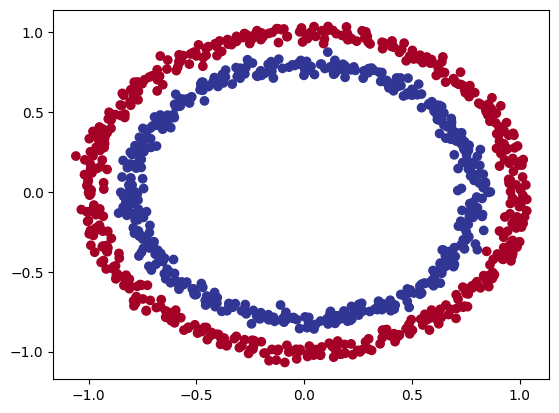

In [6]:
#Visualise
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
import torch
torch.__version__

'2.1.2'

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8, 
                                                    random_state=42)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
class CircleSplitterModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                            out_features=128)
    self.layer_2 = nn.Linear(in_features=128,
                            out_features=1)

    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.layer_1(x)
    # x = self.relu(x)
    x = self.layer_2(x)
    return x
  
model_0 = CircleSplitterModelV0().to(device)
model_0.to(device)

CircleSplitterModelV0(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [13]:
# model_0 = nn.Sequential(
#   nn.Linear(in_features=2, out_features=5),
#   nn.ReLU(),
#   nn.Linear(in_features=5, out_features=1)
# ).to(device)

In [14]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.1291, -0.4503],
                      [-0.6658, -0.0903],
                      [ 0.1269, -0.5066],
                      [-0.4527,  0.0704],
                      [ 0.4223, -0.3305],
                      [-0.0132, -0.5946],
                      [-0.1194,  0.3616],
                      [ 0.0745, -0.0396],
                      [ 0.6628,  0.3645],
                      [-0.4849,  0.6081],
                      [ 0.5315,  0.2435],
                      [ 0.5943,  0.4697],
                      [ 0.1401,  0.5089],
                      [ 0.5812,  0.1618],
                      [-0.1803, -0.2684],
                      [-0.3630, -0.5908],
                      [ 0.4675,  0.2609],
                      [-0.3159,  0.4620],
                      [-0.6385, -0.5596],
                      [ 0.2492, -0.0483],
                      [ 0.2841, -0.4145],
                      [ 0.1537,  0.2309],
                      [-0.3235,  0.2083],
  

In [15]:
#Make predictions
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.1409],
        [-0.2112],
        [-0.1304],
        [-0.1432],
        [-0.4063],
        [-0.4471],
        [-0.4264],
        [-0.4823],
        [-0.1188],
        [-0.2190]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [16]:
#setup loss function and optimizer
#binary cross entropy or categorical cross entropy for classification
# loss_fn = nn.BCELoss  requires inputs to have gone through sigmoid activation prior to input
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [17]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

going from raw logits -> prediction probabilities -> prediction labels

our model outputs are going to be raw logits

we can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binarey classification and softmax for multiclass classification)

then we can convert our models prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [18]:
#View the first 5 outputs of the forard pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
y_logits

tensor([[-0.1409],
        [-0.2112],
        [-0.1304],
        [-0.1432],
        [-0.4063],
        [-0.4471],
        [-0.4264],
        [-0.4823],
        [-0.1188],
        [-0.2190],
        [-0.1129],
        [-0.1739],
        [-0.4637],
        [-0.1735],
        [-0.0791],
        [-0.4463],
        [-0.3117],
        [-0.0695],
        [-0.1046],
        [-0.0517],
        [-0.2088],
        [-0.5096],
        [-0.0911],
        [-0.0395],
        [-0.3646],
        [-0.4468],
        [-0.2769],
        [-0.4951],
        [-0.0606],
        [-0.2150],
        [-0.3771],
        [-0.3493],
        [-0.1234],
        [-0.3370],
        [-0.1021],
        [-0.2465],
        [-0.1570],
        [-0.1583],
        [-0.2992],
        [-0.1919],
        [-0.0826],
        [-0.0975],
        [-0.3160],
        [-0.4188],
        [-0.1192],
        [-0.2614],
        [-0.4433],
        [-0.2008],
        [-0.2328],
        [-0.4303],
        [-0.1382],
        [-0.1204],
        [-0.

In [19]:
# use the sigmoid activation function on our model logits to turn them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4648],
        [0.4474],
        [0.4674],
        [0.4643],
        [0.3998],
        [0.3901],
        [0.3950],
        [0.3817],
        [0.4703],
        [0.4455],
        [0.4718],
        [0.4566],
        [0.3861],
        [0.4567],
        [0.4802],
        [0.3902],
        [0.4227],
        [0.4826],
        [0.4739],
        [0.4871],
        [0.4480],
        [0.3753],
        [0.4772],
        [0.4901],
        [0.4098],
        [0.3901],
        [0.4312],
        [0.3787],
        [0.4849],
        [0.4465],
        [0.4068],
        [0.4136],
        [0.4692],
        [0.4165],
        [0.4745],
        [0.4387],
        [0.4608],
        [0.4605],
        [0.4257],
        [0.4522],
        [0.4794],
        [0.4756],
        [0.4217],
        [0.3968],
        [0.4702],
        [0.4350],
        [0.3909],
        [0.4500],
        [0.4421],
        [0.3941],
        [0.4655],
        [0.4699],
        [0.3787],
        [0.4032],
        [0.3971],
        [0

for our prediction probability values, we need to perform a range-style rounding on them:

`y_pred_probs` >= 0.5, `y=1`

`y_pred_probs` < 0.5, `y=0`

In [20]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [21]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

#check for equality to show y_pred_labels in one line is the same thing
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

Building a training and testing loop

In [22]:
device

'cuda'

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 600

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  #forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  #loss and accuracy
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #optimizer zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    #fordward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #test loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70515, Acc: 50.00% | Test loss: 0.69511, Test acc: 47.00%
Epoch: 10 | Loss: 0.69300, Acc: 50.75% | Test loss: 0.69439, Test acc: 47.00%
Epoch: 20 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69465, Test acc: 45.00%
Epoch: 30 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 40 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 50 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 60 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 70 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 80 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 90 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 100 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 110 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 120 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, T

In [24]:
from helper_functions import plot_predictions, plot_decision_boundary

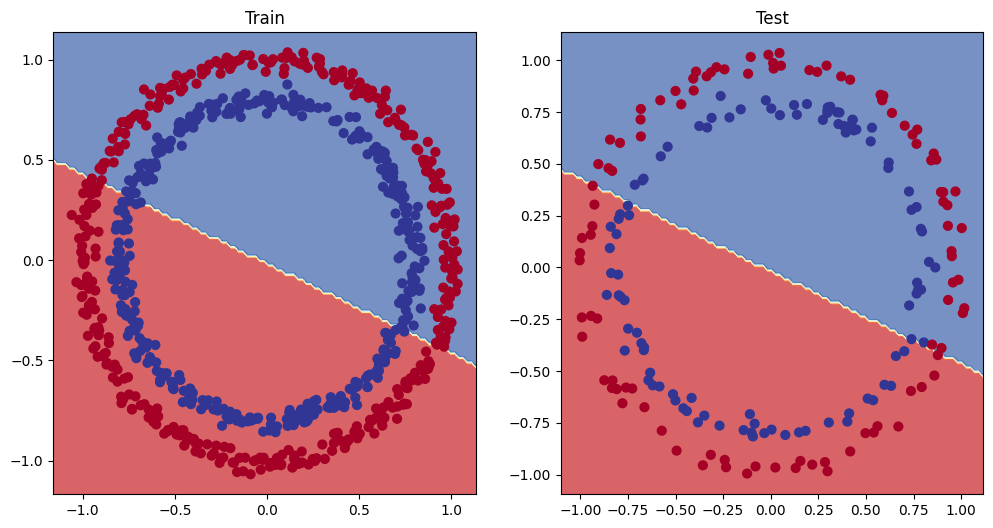

In [25]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

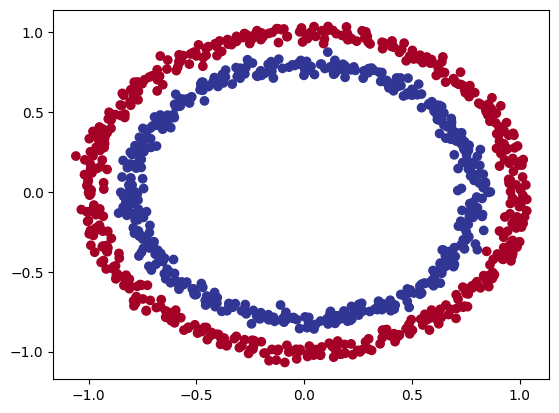

In [26]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [27]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [28]:
from torch import nn
class CircleSplitterModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                            out_features=16)
    self.layer_2 = nn.Linear(in_features=16,
                            out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)*4
    x = self.layer_2(x)
    return x
  
model_1 = CircleSplitterModelV2()
model_1.to(device)

CircleSplitterModelV2(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [29]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_1.train()

  #make prediction
  #calculate loss
  #zero grad
  #back prop
  #optim step

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72411, Acc: 50.00% | Test loss: 0.68821, Test acc: 59.00%
Epoch: 100 | Loss: 0.59420, Acc: 94.12% | Test loss: 0.60050, Test acc: 93.50%
Epoch: 200 | Loss: 0.45019, Acc: 99.38% | Test loss: 0.48122, Test acc: 99.00%
Epoch: 300 | Loss: 0.49991, Acc: 60.00% | Test loss: 0.53832, Test acc: 60.50%
Epoch: 400 | Loss: 0.40314, Acc: 74.12% | Test loss: 0.45326, Test acc: 70.00%
Epoch: 500 | Loss: 0.26356, Acc: 92.00% | Test loss: 0.31852, Test acc: 84.50%
Epoch: 600 | Loss: 0.12006, Acc: 100.00% | Test loss: 0.15737, Test acc: 99.50%
Epoch: 700 | Loss: 0.08843, Acc: 100.00% | Test loss: 0.12355, Test acc: 100.00%
Epoch: 800 | Loss: 0.06887, Acc: 100.00% | Test loss: 0.10219, Test acc: 100.00%
Epoch: 900 | Loss: 0.05595, Acc: 100.00% | Test loss: 0.08768, Test acc: 100.00%


In [31]:
from helper_functions import plot_predictions, plot_decision_boundary

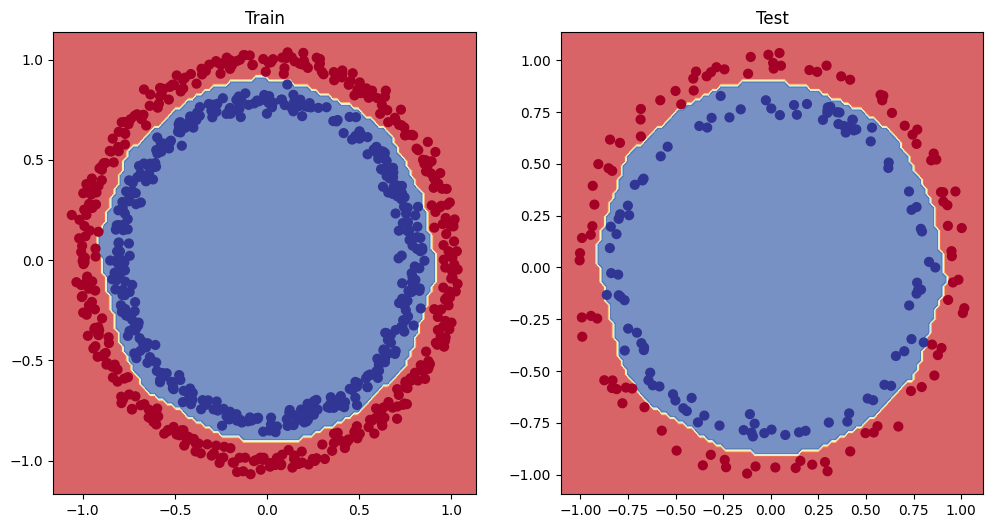

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [33]:
#Now for multiclass classification

cuda


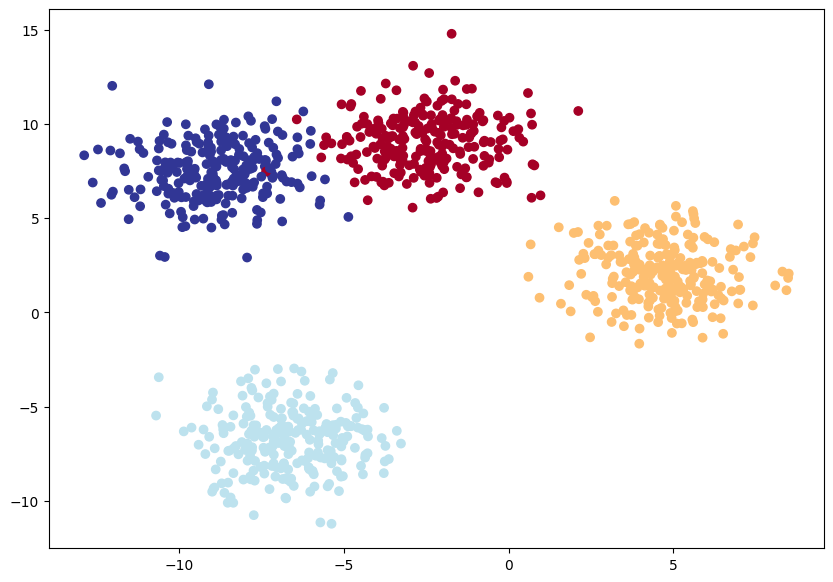

In [34]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#create multi class data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

#turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#split into train test

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


In [35]:
class MultiClassModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    # self.linear_layer_stack = nn.Sequential(
    #   nn.Linear(in_features=input_features, out_features=hidden_units),
    #   nn.ReLU(),
    #   nn.Linear(in_features=hidden_units, out_features=hidden_units),
    #   nn.ReLU(),
    #   nn.Linear(in_features=hidden_units, out_features=output_features)
    # )
    self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
    self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
    self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
    self.relu = nn.ReLU()
  def forward(self, x):
    # return self.linear_layer_stack(x)
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)
    return x

multi_class_model = MultiClassModel(input_features=2,
                                    output_features=4,
                                    hidden_units=8)


In [36]:
multi_class_model.to(device)

MultiClassModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [37]:
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

In [38]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=multi_class_model.parameters(), lr=0.01)

In [40]:
# multi_class_model.eval()
# with torch.inference_mode():
#   y_logits = multi_class_model(X_blob_test)
#   y_pred_probs = torch.softmax(y_logits, dim=1)
#   y_pred = y_pred_probs.argmax(dim=1).type(torch.long)

# y_pred[:10], y_pred_probs[:10], y_blob_test[:10]

In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  multi_class_model.train()

  y_logits = multi_class_model(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1).type(torch.float)

  loss = loss_fn(y_logits, y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  multi_class_model.eval()
  with torch.inference_mode():
    test_logits = multi_class_model(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1).type(torch.float)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
  
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test loss: 1.14724, Test acc: 38.50%
Epoch: 100 | Loss: 0.64382, Acc: 96.88% | Test loss: 0.68117, Test acc: 97.00%
Epoch: 200 | Loss: 0.41891, Acc: 98.62% | Test loss: 0.44228, Test acc: 100.00%
Epoch: 300 | Loss: 0.23740, Acc: 99.25% | Test loss: 0.24455, Test acc: 99.50%
Epoch: 400 | Loss: 0.10433, Acc: 99.25% | Test loss: 0.10148, Test acc: 99.50%
Epoch: 500 | Loss: 0.06482, Acc: 99.25% | Test loss: 0.05914, Test acc: 99.50%
Epoch: 600 | Loss: 0.05031, Acc: 99.25% | Test loss: 0.04355, Test acc: 99.50%
Epoch: 700 | Loss: 0.04289, Acc: 99.25% | Test loss: 0.03538, Test acc: 99.50%
Epoch: 800 | Loss: 0.03833, Acc: 99.25% | Test loss: 0.03022, Test acc: 99.50%
Epoch: 900 | Loss: 0.03527, Acc: 99.25% | Test loss: 0.02690, Test acc: 99.50%


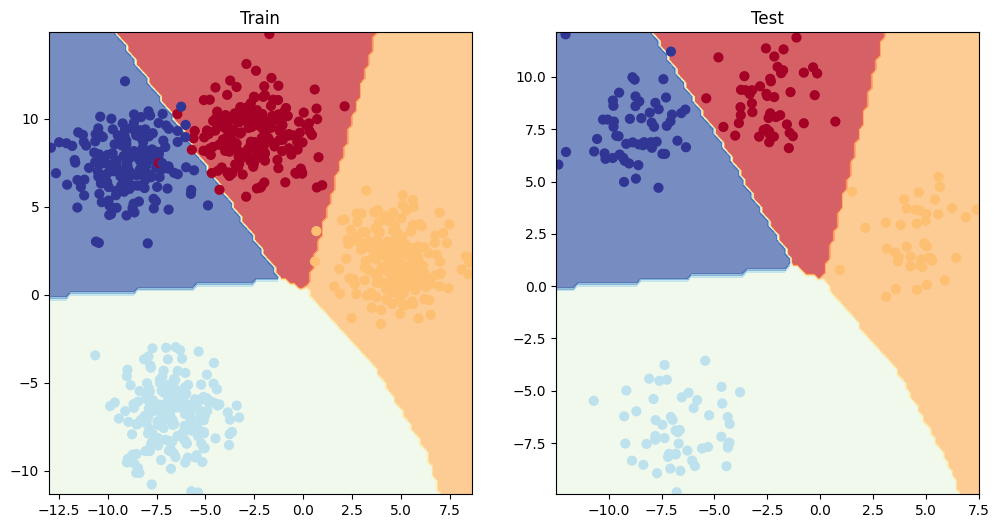

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(multi_class_model, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(multi_class_model, X_blob_test, y_blob_test)

In [43]:
multi_class_model.to(device)

MultiClassModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [44]:
multi_class_model.eval()
with torch.inference_mode():
  y_logits = multi_class_model(X_blob_test)
y_logits[:10]

tensor([[-0.6780,  5.9374, -7.5888, -8.3576],
        [-2.1662, -6.3420, -3.7323,  3.1173],
        [-3.4562, -3.9502,  3.1581, -2.6437],
        [-1.1644,  4.1617, -3.8413, -4.8268],
        [ 3.7170, -1.3749, -9.0873, -6.8768],
        [-2.8119, -7.5421, -4.3044,  3.7828],
        [-3.0704, -3.3803,  2.7892, -2.1602],
        [ 3.3590, -4.0543, -6.8652, -3.5161],
        [-4.4254, -5.0603,  3.8233, -3.4248],
        [ 3.4808, -3.0514, -7.4990, -4.6582]], device='cuda:0')

In [45]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3378e-03, 9.9866e-01, 1.3337e-06, 6.1826e-07],
        [5.0432e-03, 7.7475e-05, 1.0533e-03, 9.9383e-01],
        [1.3341e-03, 8.1406e-04, 9.9485e-01, 3.0064e-03],
        [4.8373e-03, 9.9471e-01, 3.3269e-04, 1.2418e-04],
        [9.9386e-01, 6.1090e-03, 2.7321e-06, 2.4918e-05],
        [1.3653e-03, 1.2048e-05, 3.0692e-04, 9.9832e-01],
        [2.8183e-03, 2.0674e-03, 9.8811e-01, 7.0033e-03],
        [9.9833e-01, 6.0219e-04, 3.6223e-05, 1.0315e-03],
        [2.6129e-04, 1.3849e-04, 9.9889e-01, 7.1069e-04],
        [9.9824e-01, 1.4533e-03, 1.7013e-05, 2.9142e-04]], device='cuda:0')

In [46]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

In [ ]:
#a few more classification metrics (to evaluate our classification model)
# Accuracy - out of 100 samples how many does our model get right?
# Precision - 
# Recall
# F1-score
# Confusion matrix
# CLassification report


In [59]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="MULTICLASS", num_classes=4).to(device)

#Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)


tensor(0.9950, device='cuda:0')